# BLU11 - Learning Notebook - Part 1 of 2 - Collaborative Filtering

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import norm
from scipy.sparse import csr_matrix, save_npz
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"]=(4.8, 3.6)

## 1. Welcome to personalized recommendations

Imagine that a company selling video games online (like Steam or Epic Games) hires you to help them scale recommendations.

When the company was starting, there was just a handful of players and games. Early customers were somewhat similar, given that most came from word-of-mouth, and people in the real world tend to share advice with friends and family with similar tastes. Games were not incredibly diverse either, as they were highly curated by the company according to pre-defined criteria such as genre or storytelling.

Hence, recommendations were a hybrid of non-personalized recommenders such as best-sellers lists (given that users were more or less alike) and manual suggestions provided over the phone or via email by the company. In short, for as long as there were games available that matched the typical player, all was good.

Except that, to grow the business, the company wants to expand to new customer segments and diversify its games portfolio to grab a more significant share of the market. There is, nonetheless, a challenge: how can we efficiently match players to games in a highly diverse environment?

Enter personalized recommenders where recommendations are tailored for each user. We will explore two kinds of personalized RS: collaborative filtering in this notebook and content-based recommenders in the second.

By the way, welcome to the job! :)

### 1.1 About the data

Once you arrive at the new job, this is what you have to work with:
* The `hours_played.csv` is a table of hours played per user per game.
* The `video_games.csv` is a look-up table between video game name and id.
* The `metadata.json` is a file with video game metadata.

Collaborative filtering works inside the base model, so uses just the information about user-item interactions from the ratings matrix. We can forget the metadata for now.

#### 1.1.1 Data on hours played

The `hours_played.csv` is the record of the number of hours played per player per game.
* Each row is a game purchase identified by the corresponding `UserID` and `VideoGameID`.
* The column `HoursPlayed` refers to the total time played by the user for each game, in hours, to 1 decimal precision.
* The minimum value for `HoursPlayed` is 1.0 meaning that the user played the game for up to 1 hour.

The data is in long-format where each row is an observation, the number of hours played, for a user-item pair $(u, i) \in (U, I)$.

In [2]:
hours_played = pd.read_csv(os.path.join('data', 'hours_played.csv'))
hours_played.head()

,UserID,VideoGameID,HoursPlayed
0,0,227,5.9
1,0,852,145.0
2,0,978,1.0
3,0,984,1.0
4,0,1131,1.0


This table is the memory of the recommender system as it records the history of the entire community.

Since the engineering team kindly pre-processed the data, you can assume that:
* There is a single entry or row per user per game.
* User IDs are sequential integers, ranging from 0 to 12392.
* Video game IDs (i.e. item IDs) are also sequential integers, ranging from 0 to 5154.

Typically (in a Hackathon, for example 🤓), none of these can be safely assumed and should be ensured by the data scientist.

#### 1.1.2 Data on video games

The `video_games.csv` is just a look-up table that maps the video game IDs to the video game names.

In [3]:
video_games = pd.read_csv(os.path.join('data', 'video_games.csv'), index_col='VideoGameID')
video_games.head()

,VideoGameName
VideoGameID,
0,007 Legends
1,0RBITALIS
2,1... 2... 3... KICK IT! (Drop That Beat Like a...
3,10 Second Ninja
4,"10,000,000"


### 1.2 Building the ratings

Assuming hours played as a proxy for preference, i.e. the most played games are the most interesting, we want to build the ratings matrix $\boldsymbol{R}$.

For a community of $m$ users and $n$ items, the ratings are an $m \times n$ matrix with the users $U$ in rows and the items $I$ in columns:

$$ R = \begin{bmatrix}r_{1, 1} & r_{1, 2} & \dots & r_{1, n}\\ r_{2, 1} & r_{2, 2} & \dots & r_{2, n}\\ \dots & \dots & \dots & \dots \\ r_{m, 1} & r_{m, 2} & \dots & r_{m, n}\end{bmatrix}$$

In our case, the users are the players and the items are the games, and $m$ and $n$ are equal to 12,393 users and 5,155 items. Ratings correspond to hours played and thus can only be positive real numbers, $r_{u, i} \in \mathbb{R}_{>0}$.

We can use [df.pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) to convert the data from long to wide form and create a column for each `VideoGameID`.

In [4]:
(hours_played.pivot(index='UserID', columns='VideoGameID', values='HoursPlayed')
             .head(n=3))

VideoGameID,0,1,2,3,4,5,6,7,8,9,...,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154
UserID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We should represent the ratings matrix as sparse because most ratings are unknown to us, else we wouldn't need a fancy recommender.

In [5]:
def make_ratings(hours_played):
    return csr_matrix(hours_played.pivot(index='UserID', 
                                         columns='VideoGameID', 
                                         values='HoursPlayed')
                                  # Good practice when setting the index.
                                  .sort_index()
                                  # Convert NaN value to zeros.
                                  .fillna(0)) 


R = make_ratings(hours_played)

We were able  to transform the community history into a proper ratings matrix and we are one step closer to our goal. We save the ratings matrix to a file as it will be useful in the future.

In [6]:
save_npz(os.path.join('data', 'ratings_matrix.npz'), R)

## 2. Collaborative filtering

Now that we have the data ready, it's time for some whiteboarding. How can we go about using the ratings matrix to provide personalized recommendations? 🤔

Logically, you work under the assumption that what is true for word-of-mouth holds for personalized recommenders: that people value more highly the opinions of other people that are (or are perceived to be) most like them.

### 2.1 Collaborative recommendations

The hypothesis is that if player A and player B are similar, then you can recommend player A a game that is well-liked by player B and vice-versa. One way to measure similarity is to identify users that play the same games. In our example below,  players A and B both play game 1, so these two players must be similar in some way.

<img src="media/whiteboard.png" width="300">

Analogously, when a user plays two different games, those two games must have something in common. Thus, we can conclude:
* The more games a pair of users has in common, the more similar should the two users be.
* The more users a pair of games has in common, the more similar should the two games be. 

This approach is called collaborative, as the history of the whole community is used to provide personalized recommendations for a particular user.

### 2.2 Neighborhoods

You can take the idea one step further, inspired by the $k$-nearest neighbor (kNN) algorithm.

Based on the similarities between users or items, we can define similarity neighborhoods:
* $N^k_i(u)$ contains $k$ users chosen from those that rated the item $i$ who are the most similar to user $u$.
* $N^k_u(i)$ contains $k$ items chosen from those that were rated by the user $u$ which are the most similar to item $i$.

The maximum value of $k$ is the size of the set of all users who rated the item, $U_i$, or of the set of all ratings by the user, $I_u$, respectively.

### 2.3 Predicting ratings based on the $k$-nearest neighbors

The easiest way to predict an unknown rating $r_{ui}$ is to average the ratings of the neighbors. For example, for user-based recommendations, using the neighborhood of the user $u$ for item $i$, $N^k_i(u)$:

$$\hat{r}_{ui} = \frac{\sum_{v \in N^k_i(u)} r_{vi}}{k}$$

But you can do better: you can weigh the ratings by neighbor similarity. This approach emulates the word-of-mouth behavior - IRL you tend to trust more the people closest to you:

$$\hat{r}_{ui} = \frac{\sum_{v \in N^k_i(u)} sim(u, v)  \cdot r_{vi}}{\sum_{v \in N^k_i(u)} |sim(u, v)|}$$

The sum is normalized by the sum of the absolute values of the similarities, to account for negative similarities.

We can do the same for the item neighborhood $N^k_u(i)$:

$$\hat{r}_{ui} = \frac{\sum_{j \in N^k_u(i)} sim(i, j)  \cdot r_{uj}}{\sum_{j \in N^k_u(i)} |sim(i, j)|}$$

The item-based prediction of $r_{ui}$ is therefore the average of the ratings by user $u$ of the $k$ nearest neighbors of item $i$ weighted by the item similarity.

So collaborative filtering relies on computing predicted ratings as the average of the $k$ neighbors, weighted by the similarity.

We talk about user-user collaborative filtering when we are using the neighborhood of user $u$, $N^k_i(u)$, or item-item collaborative filtering when we are using the neighborhood of item $i$, $N^k_u(i)$.

The question remains, how do we measure user or item similarities? In previous ML problems, we have already used Euclidean distances, dot products, and cosine similarity for this purpose. Let's explore what we expect from user/item similarity in the context of this recommender system and choose our similarity metric based on that.

### 2.4 Computing similarities

The problem therefore becomes: how do we go about computing similarities? Fortunately, we already have in our toolkit an appropriate tool to solve this problem. Let's start with a few examples to get the requirements right. For the sake of conciseness, we will focus on similarities between users for now.

#### 2.4.1 Users with identical ratings

Imagine the simplest case in which we have two players, A and B, and two games, 0 and 1. The most similar users would play the same games for the same amount of time, with a ratings matrix like this:

In [7]:
example_1 = pd.DataFrame.from_dict({'A': [1000, 1000], 'B': [1000, 1000]})
example_1

,A,B
0,1000,1000
1,1000,1000


The matrix gives us the user vectors in the two-dimensional game space. In this case they are identical.

In [8]:
def plot_vectors(vectors, xlim=1100, ylim=1100):
    X, Y, U, V = zip(*vectors)
    plt.figure()
    ax = plt.gca()
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
    ax.set_xlim([-xlim, xlim])
    ax.set_ylim([-ylim, ylim])
    ax.set_xlabel('Game 0')
    ax.set_ylabel('Game 1')

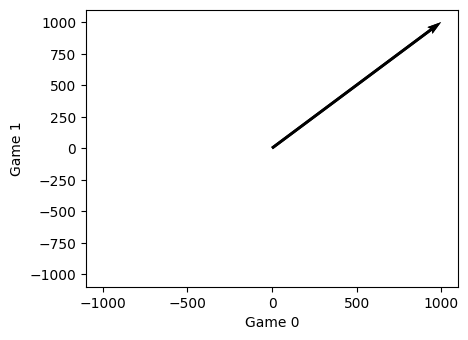

In [9]:
vectors_1 = np.array([[0, 0, 1000, 1000], [0, 0, 1000, 1000]])
plot_vectors(vectors_1)

From the representation, we understand that the users like both games equally well, as illustrated by the 45º line. As the vectors are identical, in the similarity metric we choose, the similarity between these vectors must be as high as can be.

#### 2.4.2 Does scale matter?

Now imagine two players that play the same games, but one player (player A) plays more hours. This is the ratings matrix:

In [10]:
example_2 = pd.DataFrame.from_dict({'A': [1000, 1000], 'B': [500, 500]})
example_2

,A,B
0,1000,500
1,1000,500


These vectors are collinear and have the same direction, but have different magnitudes.

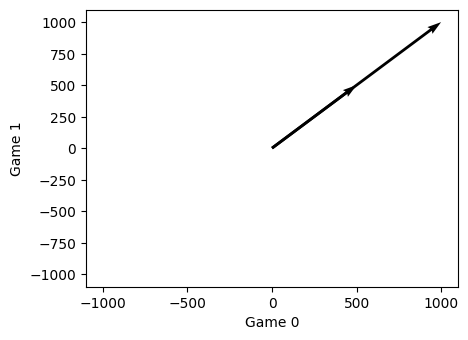

In [11]:
vectors_2 = np.array([[0, 0, 1000, 1000], [0, 0, 500, 500]])
plot_vectors(vectors_2)

In this particular case we are interested in relative preferences, i.e. how items are valued relative to each other, and thus consider only the direction and orientation and ignore the differences in vector magnitude. Henceforth, in our chosen metric, the similarity between the vectors should still be high (and exactly as high as in the last example). 

Note that metrics that consider the magnitude of the vectors, such as the [dot product](https://en.wikipedia.org/wiki/Dot_product), violate this principle. Note also that sometimes it may be desirable to consider also the magnitude.

#### 2.4.3 Users with exclusive ratings

Now, take the case in which users play exclusively different games for the same amount of time.

In [12]:
example_3 = pd.DataFrame.from_dict({'A': [1000, 0], 'B': [0, 1000]})
example_3

,A,B
0,1000,0
1,0,1000


These are users with completely different tastes. Again, we project the users into the space of the games.

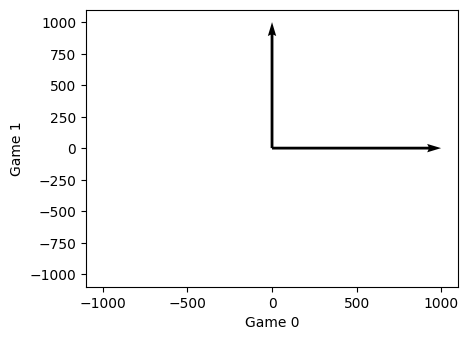

In [13]:
vectors_3 = np.array([[0, 0, 1000, 0], [0, 0, 0, 1000]])
plot_vectors(vectors_3)

The respective user vectors are orthogonal in space - there is no similarity. It means that the users have nothing in common, so our similarity metric should give zero in this case.

#### 2.4.4 What about opposite ratings?
Consider now that the company asks for feedback (e.g. a like/dislike button) from the players. This is a new situation because unlike the hours played, the feedback can be positive (1) or negative (-1). How should a similarity metric reflect this? This is our new rating matrix with the feedback of players A and B from the like/dislike button.

In [14]:
example_4 = pd.DataFrame.from_dict({'A': [1, 0], 'B': [-1, 0]})
example_4

,A,B
0,1,-1
1,0,0


Players A and B are inversely affected by game 0. While player A likes it (positive feedback), player B doesn't (negative feedback).

What can we conclude from inspecting the user vectors?

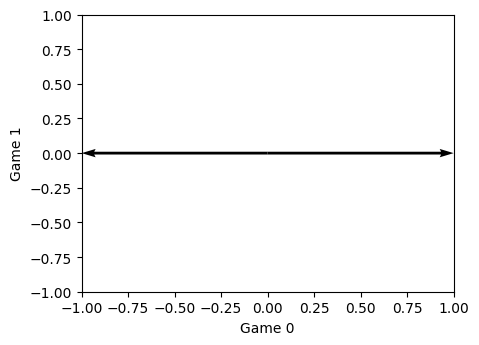

In [15]:
vectors_4 = np.array([[0, 0, 1, 0], [0, 0, -1, 0]])
plot_vectors(vectors_4, 1, 1)

The user vectors are collinear but have opposite directions and a negative similarity (i.e. they are the opposite). Thus, the similarity metric of our choice should return a negative value in this case.

We have already used such a similarity metric in the NLP specialization. Remember the cosine similarity?

#### 2.4.5 Cosine similarity

The cosine similarity, which measures the similarity of two vectors by calculating the cosine of the angle between them, fits our problem:

$$sim(u, v) = cos(\theta) = \frac{u \cdot v}{||u||\ ||v||}$$

$u$ and $v$ represent two vectors of ratings from a pair of users - two rows of the ratings matrix. In the same way, we can calculate the similarity between two item vectors - two columns of the ratings matrix.

The cosine distance is the normalized dot product, therefore unaffected by the magnitude of the vectors, and the resulting similarity ranges from -1 to 1:
* −1 meaning that the two vectors are pointing in opposite directions (example 4)
* 1 meaning that the two vectors are pointing in the same direction (examples 1 and 2)
* 0 indicating orthogonality (example 3)
* In-between values indicate intermediate similarity.

Sometimes, you will find the concept of cosine distance which is just the opposite of the cosine similarity:

$$dist(u, v) = 1- sim(u, v)$$

The higher the cosine distance, the less similar are the vectors.

Let's make a function to calculate cosine similarity for a pair of vectors and calculate it for the four examples from above.

In [16]:
def similarity(u, v):
    return round(np.dot(u, v) / (norm(u) * norm(v)), 2)


similarity(example_1.A, example_1.B)

np.float64(1.0)

In [17]:
similarity(example_2.A, example_2.B)

np.float64(1.0)

In [18]:
similarity(example_3.A, example_3.B)

np.float64(0.0)

In [19]:
similarity(example_4.A, example_4.B)

np.float64(-1.0)

See? It behaves exactly as we wanted. Of course, in other situations, another metric may be more useful for calculating the neighbor distances. You should always consider what you expect from your metric before making the choice.

Implementation time: the [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) from `sklearn.metrics.pairwise` computes the cosine similarity between samples in $A$ and $B$:

$$sim(A, B) = \frac{A \times B}{||A||\ ||B||}$$ 

$A$ and $B$ can be vectors or matrices.  The result will be a matrix of shape (n_samples_A,n_samples_B). If the inputs are sparse, we can opt to obtain a dense matrix with the `dense_output` parameter.

Our use case will be to compute the similarity between a set of user vectors (rows of the ratings matrix) or between a set of item vectors (columns of the ratings matrix). For this, we call the function with just one parameter - the ratings matrix (or it's subset) to calculate user similarities or the transposed ratings matrix to calculate item similarities.

Doing this, we can compute the cosine similarity between all vectors at once, in a vectorized and efficient way.

#### 2.4.6 Computing similarities between users

We can calculate the user similarity matrix $S_u$ containing the cosine similarity between all pairs of users $(u, v) \in U \times U$ like:

$$S_U = \frac{R \times R^T}{||R||\ ||R^T||}$$

$R$ and its transpose $R^T$ are $m \times n$ and $n \times m$ matrices, respectively. $S_u$ is an $m \times m$ matrix:

$$S_U = \begin{bmatrix}1 & cos(u_1, v_2) & \dots & cos(u_1, v_m) \\ cos(u_2, v_1) & 1 & \dots & cos(u_2, v_m) \\ \dots  & \dots & 1 & \dots \\ cos(u_m, v_1) & cos(u_m, v_2) & \dots & 1\end{bmatrix}$$

The result is a symmetric matrix. For storage purposes, you could save disk space by converting the symmetric matrix into a lower or upper triangular matrix (with all entries above or below the main diagonal being zero).

In [20]:
user_similarities = cosine_similarity(R, dense_output=False)

#### 2.4.7 Computing similarities between items

We can calculate the item similarity matrix $S_i$ containing the cosine similarity between all pairs of items $(i, j) \in I \times I$ like:

$$S_I = \frac{R^T \times R}{||R^T||\ ||R||}$$

$R^T$ and $R$ are $n \times m$ and $m \times n$ matrices, respectively. $S_I$ is a $n \times n$ symmetric matrix:

$$S_I = \begin{bmatrix}1 & cos(i_1, j_2) & \dots & cos(i_1, j_n) \\ cos(i_2, j_1) & 1 & \dots & cos(i_2, j_n) \\ \dots  & \dots & \dots & \dots \\ cos(i_n, j_1) & cos(i_n, j_2) & \dots & 1\end{bmatrix}$$

In [21]:
item_similarities = cosine_similarity(R.T, dense_output=False)

We will now use the calculated similarity matrices to make predictions. 

## 3. Making predictions

### 3.1 Predictions based on user similarities

For the sake of simplicity, for this prediction we're going to use all the user ratings of item $i$ instead of just the $k$ most similar neighbors. We will calculate the weighted average of the ratings of item $i$, using the user similarities as weights:

$$\hat{r}_{ui} = \frac{\sum_{v \in N_i(u)} sim(u, v)  \cdot r_{vi}}{\sum_{v \in N_i(u)} |sim(u, v)|}$$

In the function below, we will do the calculations for the whole community at once, using matrices. We are using `np.dot` to perform matrix multiplication here.

In [22]:
def make_user_predictions(S, R):
    """
    Calculates user-based collaborative predictions.
    
    Parameters:
        S: matrix of user similarities
        R: ratings matrix
    
    Returns:
        preds: csr matrix of predictions
    """
    # Calculate the numerator of the sum:
    weighted_sum = np.dot(S, R)
    
    # Note that in the denominator we have to explicitly 
    # select the neighbors of user u that have rated the item i.
    # Those are given by R_boolean.
    
    R_boolean = R.copy() 
    R_boolean[R_boolean != 0] = 1 # take the existing (non-zero) ratings
    # Here we divide elementwise and not taking care of zero division
    # which is unlikely to be a problem in this case.
    preds = np.divide(weighted_sum, np.abs(np.dot(S, R_boolean)))
    
    # Exclude previously rated items.
    preds[R.nonzero()] = 0
    
    return csr_matrix(preds)
 

user_preds = make_user_predictions(user_similarities, R)

Let's see how many ratings we were able to predict:

In [23]:
def sparsity(matrix):
    return 1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])


sparsity(user_preds)

0.0020161564563957457

Above, we use [nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html) to return the count of non-zero values of the matrix. The sparsity score gives us the percentage of ratings that we couldn't predict. We are missing only 0.2% of predictions! This is very very little which means that we were able to make predictions for almost every user. This happens because almost every user has neighbours.

In real life, it will most likely not happen. You may have a lot of users without neighbours. You won't be able to make predictions for users that don't have items in common with other users. In that case, the neighborhood of these users is empty, $N(u) = \emptyset$. Consequently, you will not be able to predict a significant percentage of the ratings. This is what we call the cold-start problem.

Let's plot the numbers of ratings that we were able to predict per user:

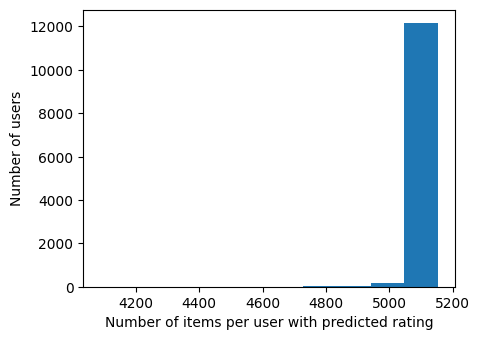

In [24]:
plt.hist(user_preds.getnnz(axis=1))
plt.xlabel('Number of items per user with predicted rating')
plt.ylabel('Number of users');

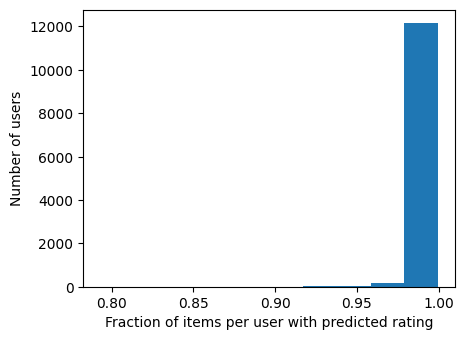

In [25]:
# same plot but with fractions instead of absolute counts
plt.hist(user_preds.getnnz(axis=1) / user_preds.shape[1])
plt.xlabel('Fraction of items per user with predicted rating')
plt.ylabel('Number of users');

From the plot above, we understand that we could predict a significant number of item ratings for most users.

Let's plot the number of neighbors per user:

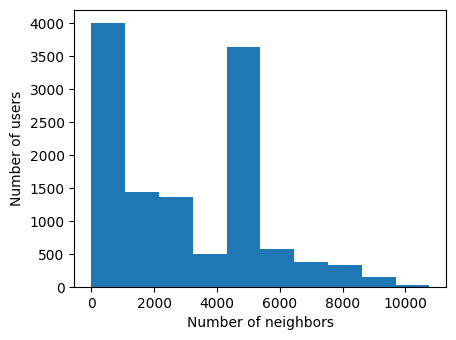

In [26]:
# The -1 is because the user_similarities matrix has 1 on the main diagonal
# which represents self-similarity that we don't want to consider.
user_total_neighbors = user_similarities.getnnz(axis=1) - 1
plt.hist(user_total_neighbors)
plt.xlabel('Number of neighbors')
plt.ylabel('Number of users');

From the plot above, we also realize that a significant number of users doesn't have many neighbors (i.e. users with at least one item in common). The plot below zooms in on the users with few neighbors.

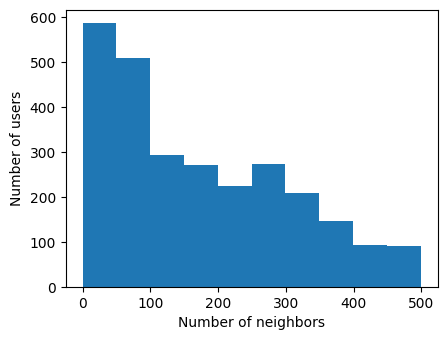

In [27]:
plt.hist(user_total_neighbors[user_total_neighbors < 500])
plt.xlabel('Number of neighbors')
plt.ylabel('Number of users');

In [28]:
user_total_neighbors[user_total_neighbors < 500].shape[0]

2701

There are 2701 users (out of 12393) with less than 500 neighbors.

In [29]:
(user_total_neighbors == 0).sum()

np.int64(19)

But only 19 users don't have neighbors, which is close to none!

For as long as one neighbor has rated the item whose rating we are predicting, we can make a prediction (although we can't assure that the prediction is any good). Hence the very very low sparsity score of the predictions matrix.

Imagine the extreme case in which a user has a single neighbor and that neighbor is not similar at all: what will we predict? Well, we'll predict that the user won't like anything that the neighbor has bought (these items will have a bad predicted rating), but we don't know how to recommend anything else, because all the other items will have a neutral predicted rating!

Also, there's a trade-off: if we limit the predictions to users with some minimum number of neighbors, possibly even accounting for minimum similarity, the sparsity of the predictions matrix increases, and we'll need to address it somehow. (Non-personalized recommendations, perhaps.)

The cold-start problem is a major limitation of collaborative-filtering that we come back to in section 5.

### 3.2 Predictions based on item similarities

Analogously, we can use $S_i$ to make predictions based on the item neighborhood, the items rated by the user $u$, $N_u(i)$:

$$\hat{r}_{ui} = \frac{\sum_{j \in N_u(i)} sim(i, j)  \cdot r_{uj}}{\sum_{j \in N_u(i)} |sim(i, j)|}$$

In [30]:
def make_item_predictions(S, R):
    """
    Calculates collaboative item-based predictions.
    
    Parameters:
        S: matrix of user similarities
        R: ratings matrix
    
    Returns:
        preds: csr matrix of predictions
    """
    
    # this is the analogous function for item predictions
    weighted_sum = np.dot(R, S)
        
    R_boolean = R.copy() 
    R_boolean[R_boolean != 0] = 1 
    preds = np.divide(weighted_sum, np.abs(np.dot(R_boolean, S)))
    
    preds[R.nonzero()] = 0
    
    return csr_matrix(preds)

 
item_preds = make_item_predictions(item_similarities, R)
sparsity(item_preds)

0.0020161564563957457

Again, we compute the sparsity score, which we realize to be the same. The histograms for the matrix of predictions that we plotted above also stays the same.

Let's plot here the histogram for the item neighbors:

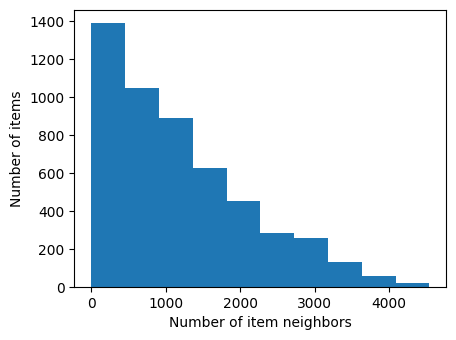

In [31]:
plt.hist(item_similarities.getnnz(axis=1))
plt.xlabel('Number of item neighbors')
plt.ylabel('Number of items');

This histogram shows us that the distribution of the number of neighbors is quite skewed to the left, i.e. the neighborhoods are mostly small. So item-based recommendations don't help us in dealing with the cold-start problem.

Empirically, item-based recommendations are considered to be more stable than user-based. It means that we don't have to recompute them as often. As an intuition for this, you can think that we usually have more interactions at the product level than at the user level: while an item will be rated/bought thousands of times, a user will only rate/buy maybe hundreds of products. So the item similarities will tend to be more reliable and change less when new interactions are added.

## 4. Filtering

Now that we have the predictions, the last step is to choose the most promising recommendations. That are several ways to do that.

### 4.1 Best-item

A typical approach is to recommend the best item, i.e. the item with the highest predicted rating. To do this, we can use [argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [32]:
def get_best_item(pred):
    return np.negative(pred).toarray().argsort()[:, :1]


get_best_item(user_preds)

array([[1606],
       [3045],
       [3045],
       ...,
       [2398],
       [1761],
       [1761]], shape=(12393, 1))

In [33]:
get_best_item(item_preds)

array([[ 687],
       [1988],
       [3421],
       ...,
       [2577],
       [3761],
       [2577]], shape=(12393, 1))

The result, in both cases, is a column-vector with the best item for each user.

Finally, we can use the `video_games` table to retrieve the name of the games from the game IDs.

In [34]:
video_games.loc[1606]

VideoGameName    FIFA Manager 09
Name: 1606, dtype: object

In [35]:
video_games.loc[687]

VideoGameName    Bus-Simulator 2012
Name: 687, dtype: object

### 4.2 Top-N

Perhaps the most typical task, however, is to recommend a top-N list to the user, i.e. the N items with the best ratings.

In [36]:
def get_top_n(pred, n):
    pred_ = np.negative(pred).toarray()
    return pred_.argsort()[:, :n]


get_top_n(user_preds, 5)

array([[1606, 1762, 5019, 2392, 3045],
       [3045, 1606, 1762, 5019, 1763],
       [3045, 1761, 1760, 1762, 1606],
       ...,
       [2398, 1559, 1765, 4343, 4663],
       [1761, 1762, 1765, 1795, 3834],
       [1761, 1762, 1765, 1795, 3834]], shape=(12393, 5))

In [37]:
get_top_n(item_preds, 5)

array([[ 687, 3421, 1007,  504, 4457],
       [1988, 4079, 3958,  108, 2527],
       [3421, 4954, 4951, 4953, 4685],
       ...,
       [2577, 3118, 3119, 3121, 3122],
       [3761, 2992, 4410,  641, 1283],
       [2577, 3312, 3300, 3299, 3298]], shape=(12393, 5))

Each row in the matrix are the top N items for the given user. Again, let's look at the game names.

In [38]:
video_games.loc[1762]

VideoGameName    Football Manager 2012
Name: 1762, dtype: object

In [39]:
video_games.loc[5019]

VideoGameName    Worldwide Soccer Manager 2009
Name: 5019, dtype: object

In [40]:
video_games.loc[3421]

VideoGameName    Radial Impact
Name: 3421, dtype: object

In [41]:
video_games.loc[1007]

VideoGameName    Cricket Captain 2014
Name: 1007, dtype: object

The first user is clearly a sports fan. Back to the cold-start problem now.

## 5. The cold-start problem

The cold-start problem means that there is a minimum critical mass of users and items connected through ratings that are required for collaborative filtering to work. Intuitively, this makes much sense. The more ratings we have, the better and more complete are the similarity matrices and the more accurate are the predictions.

Also, even in significantly connected communities, new users always face the cold-start problem, as either:
* There is not enough information to identify similar users, because the neighborhood $N(u)$ is nonexistent at first and only grows slowly.
* There are not enough ratings from the user to compute predictions based on item similarities.

The same applies to new items. Hence, we need techniques that are more robust to this problem if we want to have (1) more complete and (2) better predictions. We'll look at one of them in the next notebook.